<center>

# **22AIE401 - Reinforcement Learning**  
# **Lab 9**  

</center>

### Team Members:
- Guruprasath M R - AIE22015  
- Rudraksh Mohanty - AIE22046  
- Shree Prasad M - AIE22050  
- Tharun Kaarthik G K - AIE22062  

---

### Objective:
Transfer Learning in Autonomous Farming To demonstrate the power of Transfer Learning in reinforcement learning by adapting a crop-monitoring robot’s navigation policy from one field (Field A) to a new field (Field B) with different crop layouts and hazards. The goal is to minimize time and damage while scanning all rows and reaching the base station.


---

### Problem Statement:
An autonomous robot has been trained to navigate Field A, which is organized with evenly spaced crop rows and water puddles (hazards). The robot must learn the most efficient route to: Visit all inspection checkpoints (marked on certain crops), Avoid water puddles, Reach the base station to upload data. Now, the robot is transferred to Field B, where: Crop rows are curved or uneven,  New puddles and rocks appear. The base station is in a different location.
 


---

## Original Code

C:\Users\CH.EN.U4AIE22046\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127937 (\N{CHEQUERED FLAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\CH.EN.U4AIE22046\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128683 (\N{NO ENTRY SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\CH.EN.U4AIE22046\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128167 (\N{DROPLET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


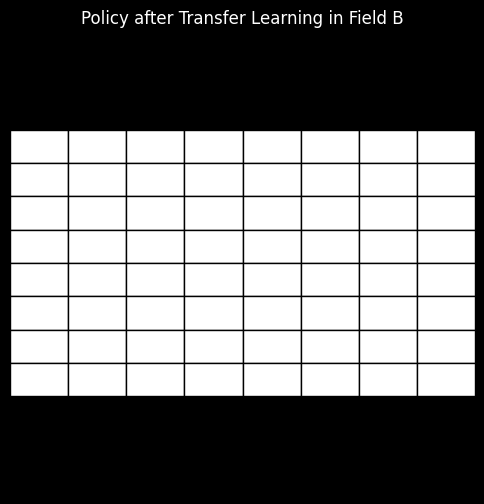

       Best Action
(0, 0)           L
(1, 0)           R
(0, 1)           U
(2, 0)           D
(0, 2)           R


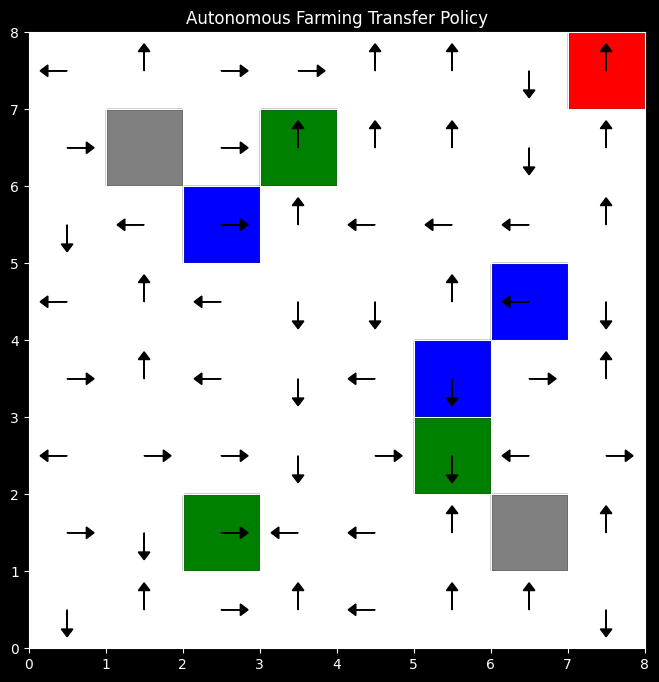

In [21]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import matplotlib.patches as patches

# Environment settings
GRID_SIZE = 8
CHECKPOINTS_A = {(2, 2), (4, 4), (6, 1)}
CHECKPOINTS_B = {(1, 3), (5, 5), (6, 2)}
PUDDLES_A = {(3, 3), (5, 5), (2, 6)}
PUDDLES_B = {(2, 2), (4, 5), (3, 6)}
OBSTACLES = {(1, 1), (6, 6)}
BASE_A = (7, 7)
BASE_B = (0, 7)

ACTIONS = ['U', 'D', 'L', 'R']
ACTION_MAP = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}

# Q-learning parameters
EPISODES = 300
ALPHA = 0.1
GAMMA = 0.9
EPSILON = 0.2
MAX_STEPS = 200

def is_valid(state):
    x, y = state
    return 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE and state not in OBSTACLES

def step(state, action, config, visited_checkpoints):
    dx, dy = ACTION_MAP[action]
    next_state = (state[0] + dx, state[1] + dy)
    
    if not is_valid(next_state):
        next_state = state
    
    reward = -1
    
    if next_state in config["puddles"]:
        reward = -5
    elif next_state in config["checkpoints"] and next_state not in visited_checkpoints:
        reward = 5
        visited_checkpoints.add(next_state)
    elif next_state == config["base"] and visited_checkpoints == config["checkpoints"]:
        reward = 10
    
    return next_state, reward, visited_checkpoints

def select_action(Q, state):
    if np.random.rand() < EPSILON or state not in Q:
        return np.random.choice(ACTIONS)
    return max(Q[state], key=Q[state].get)

def train(config, Q=None):
    if Q is None:
        Q = {}
    
    for ep in range(EPISODES):
        state = (0, 0)
        visited_checkpoints = set()
        
        for _ in range(MAX_STEPS):
            if state not in Q:
                Q[state] = {a: 0 for a in ACTIONS}
            
            action = select_action(Q, state)
            next_state, reward, visited_checkpoints = step(state, action, config, visited_checkpoints)
            
            if next_state not in Q:
                Q[next_state] = {a: 0 for a in ACTIONS}
            
            Q[state][action] += ALPHA * (
                reward + GAMMA * max(Q[next_state].values()) - Q[state][action]
            )
            
            if next_state == config["base"] and visited_checkpoints == config["checkpoints"]:
                break
            
            state = next_state
    
    return Q

# Configurations
config_A = {"checkpoints": CHECKPOINTS_A, "puddles": PUDDLES_A, "base": BASE_A}
config_B = {"checkpoints": CHECKPOINTS_B, "puddles": PUDDLES_B, "base": BASE_B}

# Train in Field A
Q_A = train(config_A)

# Save and load Q-table
with open("Q_fieldA.pkl", "wb") as f:
    pickle.dump(Q_A, f)

with open("Q_fieldA.pkl", "rb") as f:
    Q_loaded = pickle.load(f)

# Transfer to Field B
Q_transfer = train(config_B, Q=Q_loaded)

# Visualization
def plot_policy(Q, config, title):
    grid = np.full((GRID_SIZE, GRID_SIZE), '⬜', dtype='<U2')
    arrows = {'U': '↑', 'D': '↓', 'L': '←', 'R': '→'}
    
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            pos = (i, j)
            if pos in OBSTACLES:
                grid[i][j] = '🚫'
            elif pos in config["puddles"]:
                grid[i][j] = '💧'
            elif pos in config["checkpoints"]:
                grid[i][j] = '✔'
            elif pos == config["base"]:
                grid[i][j] = '🏁'
            elif pos in Q:
                best_a = max(Q[pos], key=Q[pos].get)
                grid[i][j] = arrows[best_a]
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(title)
    ax.axis('off')
    table = ax.table(cellText=grid, loc='center', cellLoc='center')
    table.scale(1, 2)
    plt.show()

# Display policy and table
plot_policy(Q_transfer, config_B, "Policy after Transfer Learning in Field B")

df = pd.DataFrame.from_dict({k: max(v, key=v.get) for k, v in Q_transfer.items()}, 
                           orient='index', columns=['Best Action'])
print(df.head())

def visualize_policy(Q, config, title="Policy Visualization"):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, GRID_SIZE)
    ax.set_ylim(0, GRID_SIZE)
    ax.set_title(title)
    ax.set_xticks(np.arange(0, GRID_SIZE+1, 1))
    ax.set_yticks(np.arange(0, GRID_SIZE+1, 1))
    ax.grid(True)
    
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            state = (i, j)
            if state in OBSTACLES:
                rect = patches.Rectangle((j, GRID_SIZE-i-1), 1, 1, 
                                       linewidth=1, edgecolor='black', facecolor='gray')
            elif state in config["puddles"]:
                rect = patches.Rectangle((j, GRID_SIZE-i-1), 1, 1, 
                                       linewidth=1, edgecolor='black', facecolor='blue')
            elif state in config["checkpoints"]:
                rect = patches.Rectangle((j, GRID_SIZE-i-1), 1, 1, 
                                       linewidth=1, edgecolor='black', facecolor='green')
            elif state == config["base"]:
                rect = patches.Rectangle((j, GRID_SIZE-i-1), 1, 1, 
                                       linewidth=1, edgecolor='black', facecolor='red')
            else:
                rect = patches.Rectangle((j, GRID_SIZE-i-1), 1, 1, 
                                       linewidth=0.5, edgecolor='black', facecolor='white')
            
            ax.add_patch(rect)
            
            if state in Q:
                best_action = max(Q[state], key=Q[state].get)
                dx, dy = {'U': (0, 0.25), 'D': (0, -0.25), 'L': (-0.25, 0), 'R': (0.25, 0)}[best_action]
                ax.arrow(j + 0.5, GRID_SIZE - i - 0.5, dx, dy, 
                        head_width=0.15, head_length=0.1, fc='black', ec='black')
    
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

visualize_policy(Q_transfer, config_B, title="Autonomous Farming Transfer Policy")

### TASK-1
Train a policy in Field A with a fixed crop layout. Then transfer the policy to Field B with rotated or shifted crops and measure how much re-learning is needed using fine-tuning vs. retraining. 

### TASK-1 — Changes vs Original (Short)
- Added evaluation and tracking to compare fine-tuning vs. retraining in Field B.
- Independent training functions; no edits to the original cell.
- Dark theme plots with vibrant colors (gold, teal, orange).

TASK-1: Training baseline on Field A, then fine-tune vs retrain on Field B…
Field A Success: 100.0%  Field B (Transfer): 100.0%  Field B (Scratch): 100.0%
Field A Success: 100.0%  Field B (Transfer): 100.0%  Field B (Scratch): 100.0%


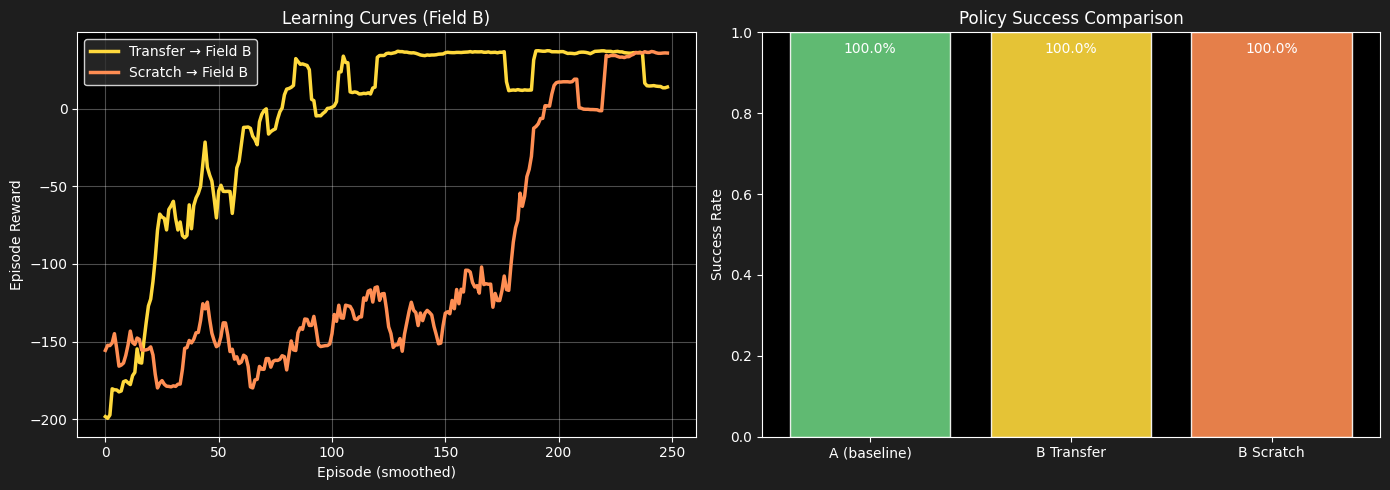

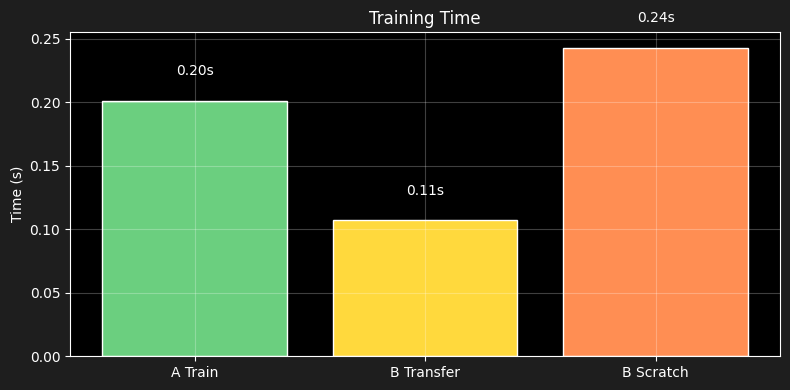

In [31]:
# TASK-1: Independent Transfer vs. Retrain (based on original)
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Dark theme + vibrant palette
plt.style.use('dark_background')
COLORS = {
    'gold': '#FFD93D',
    'teal': '#6BCF7F',
    'orange': '#FF8E53',
    'cyan': '#4CC9F0',
    'magenta': '#F72585'
}

# Environment (same layout idea as original, self-contained)
GRID_SIZE = 8
ACTIONS = ['U', 'D', 'L', 'R']
ACTION_MAP = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}

CHECKPOINTS_A = {(2, 2), (4, 4), (6, 1)}
CHECKPOINTS_B = {(1, 3), (5, 5), (6, 2)}
PUDDLES_A = {(3, 3), (5, 5), (2, 6)}
PUDDLES_B = {(2, 2), (4, 5), (3, 6)}
OBSTACLES = {(1, 1), (6, 6)}
BASE_A = (7, 7)
BASE_B = (0, 7)

config_A = {"checkpoints": CHECKPOINTS_A, "puddles": PUDDLES_A, "base": BASE_A}
config_B = {"checkpoints": CHECKPOINTS_B, "puddles": PUDDLES_B, "base": BASE_B}

# Q-learning params
EPISODES = 260
ALPHA = 0.12
GAMMA = 0.92
EPSILON = 0.30
MIN_EPS = 0.05
MAX_STEPS = 200
SHAPING_COEF = 0.4

rng = np.random.default_rng(42)

def is_valid(state):
    x, y = state
    return 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE and state not in OBSTACLES

def manhattan(a, b):
    return abs(a[0]-b[0]) + abs(a[1]-b[1])

def next_goal(state, visited, config):
    remaining = list(config["checkpoints"] - visited)
    if remaining:
        # nearest unvisited checkpoint
        return min(remaining, key=lambda g: manhattan(state, g))
    return config["base"]

def step(state, action, config, visited):
    # distance shaping to the next logical goal
    goal_before = next_goal(state, visited, config)
    d0 = manhattan(state, goal_before)

    dx, dy = ACTION_MAP[action]
    next_state = (state[0] + dx, state[1] + dy)
    if not is_valid(next_state):
        next_state = state

    reward = -1  # step cost
    if next_state in config["puddles"]:
        reward = -6
    elif next_state in config["checkpoints"] and next_state not in visited:
        visited.add(next_state)
        reward = 8
    elif next_state == config["base"] and visited == config["checkpoints"]:
        reward = 30

    goal_after = next_goal(next_state, visited, config)
    d1 = manhattan(next_state, goal_after)
    shaping = SHAPING_COEF * (d0 - d1)
    reward += shaping

    return next_state, reward, visited

def select_action(Q, s, eps):
    if s not in Q or rng.random() < eps:
        return rng.choice(ACTIONS)
    return max(Q[s], key=Q[s].get)

def train_with_tracking(config, episodes=EPISODES, Q=None, eps0=EPSILON):
    Q = defaultdict(lambda: {a: 0.0 for a in ACTIONS}) if Q is None else Q
    history = []
    t0 = time.time()
    for ep in range(episodes):
        s = (0, 0)
        visited = set()
        ep_reward = 0.0
        eps = max(MIN_EPS, eps0 * (1 - ep/episodes))
        for _ in range(MAX_STEPS):
            a = select_action(Q, s, eps)
            ns, r, visited = step(s, a, config, visited)
            if ns not in Q:
                Q[ns] = {aa: 0.0 for aa in ACTIONS}
            Q[s][a] += ALPHA * (r + GAMMA * max(Q[ns].values()) - Q[s][a])
            ep_reward += r
            if ns == config["base"] and visited == config["checkpoints"]:
                break
            s = ns
        history.append(ep_reward)
    t = time.time() - t0
    return Q, history, t

def evaluate_policy(Q, config, episodes=80):
    succ, rewards = 0, []
    for _ in range(episodes):
        s = (0, 0)
        visited = set()
        total = 0.0
        for _ in range(MAX_STEPS):
            a = rng.choice(ACTIONS) if s not in Q else max(Q[s], key=Q[s].get)
            ns, r, visited = step(s, a, config, visited)
            total += r
            if ns == config["base"] and visited == config["checkpoints"]:
                succ += 1
                break
            s = ns
        rewards.append(total)
    return {
        'success_rate': succ/episodes,
        'avg_reward': float(np.mean(rewards)),
        'std_reward': float(np.std(rewards))
    }

print("TASK-1: Training baseline on Field A, then fine-tune vs retrain on Field B…")
# Baseline on Field A
Q_A, hist_A, time_A = train_with_tracking(config_A)

# Fine-tune (transfer) on Field B
Q_transfer = {k: v.copy() for k, v in Q_A.items()}
Q_transfer, hist_transfer, time_transfer = train_with_tracking(config_B, Q=Q_transfer, eps0=EPSILON*0.8)

# Retrain from scratch on Field B
Q_scratch, hist_scratch, time_scratch = train_with_tracking(config_B)

# Evaluate
E_A = evaluate_policy(Q_A, config_A)
E_T = evaluate_policy(Q_transfer, config_B)
E_S = evaluate_policy(Q_scratch, config_B)

print("Field A Success:", f"{E_A['success_rate']:.1%}", " Field B (Transfer):", f"{E_T['success_rate']:.1%}", " Field B (Scratch):", f"{E_S['success_rate']:.1%}")

# Visualization — Learning curves + bars (dark theme, vibrant colors)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), facecolor='#1e1e1e')

# Learning curves in Field B
def smooth(x, k=12):
    if len(x) < k:
        return x
    return np.convolve(x, np.ones(k)/k, mode='valid')

ax1.plot(smooth(hist_transfer), color=COLORS['gold'], linewidth=2.5, label='Transfer → Field B')
ax1.plot(smooth(hist_scratch), color=COLORS['orange'], linewidth=2.5, label='Scratch → Field B')
ax1.set_title('Learning Curves (Field B)', color='white')
ax1.set_xlabel('Episode (smoothed)')
ax1.set_ylabel('Episode Reward')
ax1.grid(True, alpha=0.3, color='white')
ax1.legend(facecolor='#2e2e2e', edgecolor='white', labelcolor='white')
ax1.tick_params(colors='white')

# Success bars
labels = ['A (baseline)', 'B Transfer', 'B Scratch']
success = [E_A['success_rate'], E_T['success_rate'], E_S['success_rate']]
ax2.bar(labels, success, color=[COLORS['teal'], COLORS['gold'], COLORS['orange']], edgecolor='white', linewidth=1, alpha=0.9)
ax2.set_ylim(0, 1)
ax2.set_ylabel('Success Rate', color='white')
ax2.set_title('Policy Success Comparison', color='white')
ax2.tick_params(colors='white')
for i, v in enumerate(success):
    ax2.text(i, min(0.95, v + 0.02), f"{v:.1%}", ha='center', color='white')

plt.tight_layout()
plt.show()

# Timing
fig, ax = plt.subplots(figsize=(8, 4), facecolor='#1e1e1e')
ax.bar(['A Train', 'B Transfer', 'B Scratch'], [time_A, time_transfer, time_scratch], color=[COLORS['teal'], COLORS['gold'], COLORS['orange']], edgecolor='white', linewidth=1)
ax.set_ylabel('Time (s)', color='white')
ax.set_title('Training Time', color='white')
for i, v in enumerate([time_A, time_transfer, time_scratch]):
    ax.text(i, v + 0.02, f"{v:.2f}s", ha='center', color='white')
ax.tick_params(colors='white')
ax.grid(True, alpha=0.25, color='white')
plt.tight_layout()
plt.show()

### TASK-2
Simulate vision-based crop detection by representing different crops with RGB/Greyscale grid tiles. Transfer a policy trained on color data to a shape-based grayscale version and observe performance changes.

### TASK-2 — Changes vs Original (Short)
- Simulated RGB vs. grayscale vision and cross-modal transfer.
- Separate vision-aware training (feature-based state) independent of other tasks.
- Dark theme plots and side-by-side grid previews.

TASK-2: Train on color vision, then transfer to grayscale…


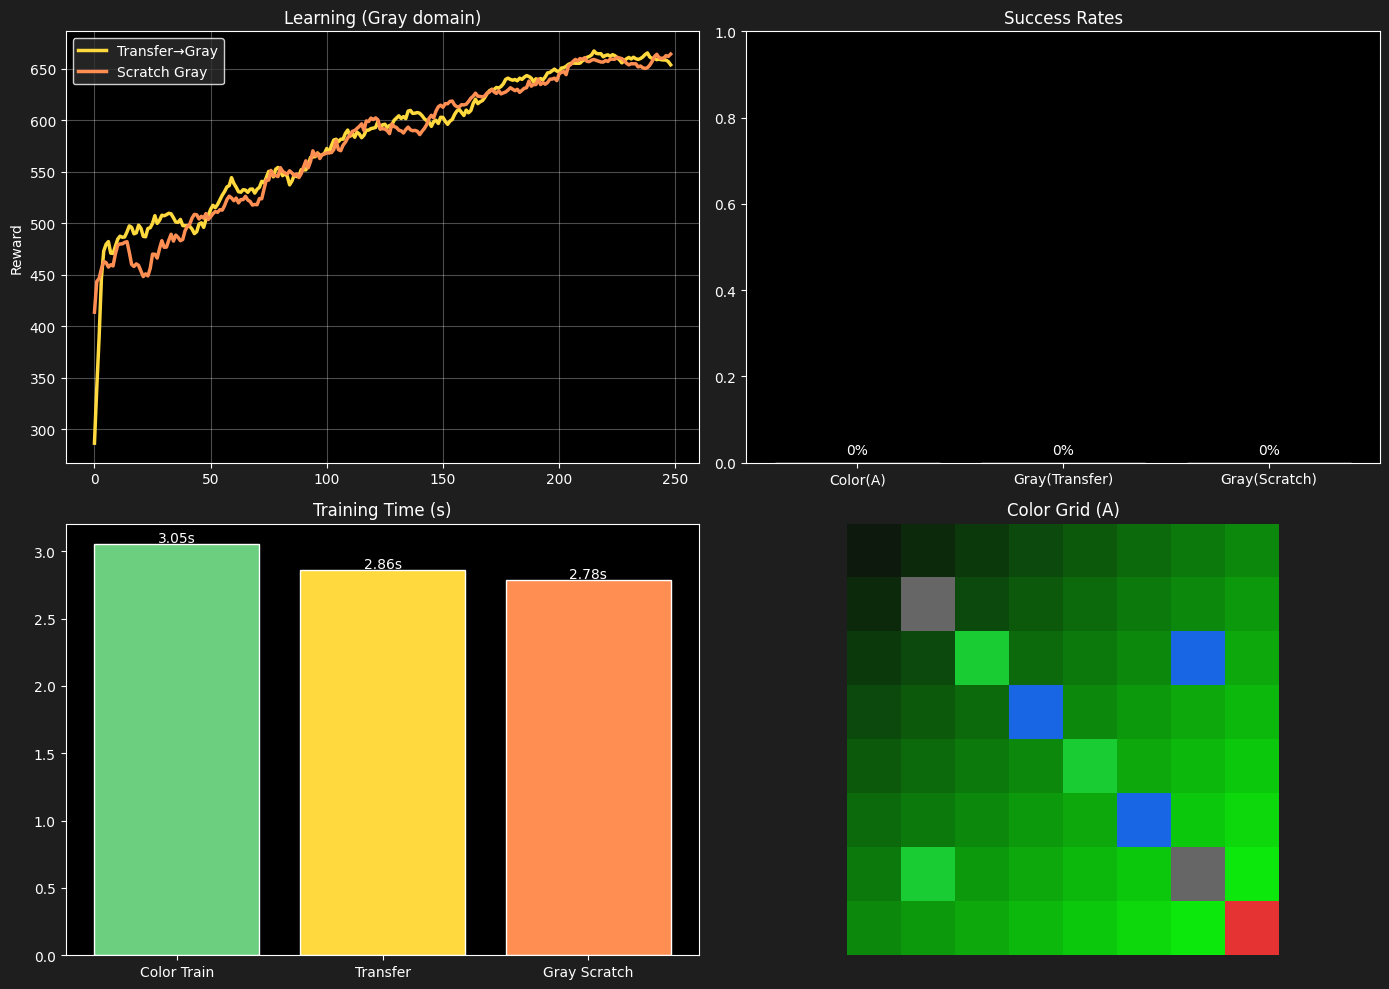

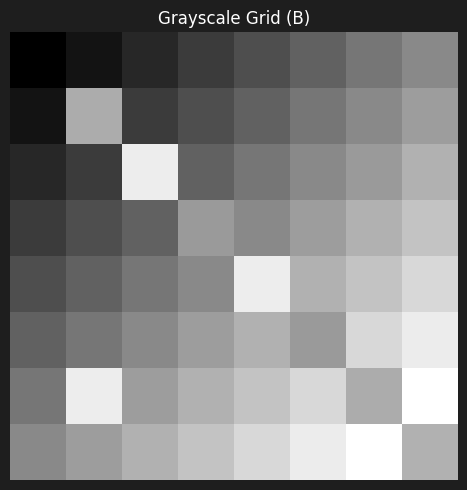

In [32]:
# TASK-2: Independent Vision-based Transfer (RGB → Grayscale)
import numpy as np
import matplotlib.pyplot as plt
import time

plt.style.use('dark_background')
COLORS = {'gold': '#FFD93D', 'teal': '#6BCF7F', 'orange': '#FF8E53'}

GRID_SIZE = 8
ACTIONS = ['U', 'D', 'L', 'R']
ACTION_MAP = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}

CHECKPOINTS = {(2, 2), (4, 4), (6, 1)}
PUDDLES = {(3, 3), (5, 5), (2, 6)}
BASE = (7, 7)
OBSTACLES = {(1, 1), (6, 6)}

EPISODES = 260
ALPHA = 0.12
GAMMA = 0.92
EPSILON = 0.30
MIN_EPS = 0.05
MAX_STEPS = 200
rng = np.random.default_rng(123)

# Utility
manhattan = lambda a, b: abs(a[0]-b[0]) + abs(a[1]-b[1])

def is_valid(s):
    x, y = s
    return 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE and s not in OBSTACLES

def make_color_grid():
    grid = np.zeros((GRID_SIZE, GRID_SIZE, 3), dtype=float)
    grid[:, :, 1] = 0.1
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            pos = (i, j)
            if pos in OBSTACLES:
                grid[i, j] = [0.4, 0.4, 0.4]
            elif pos in PUDDLES:
                grid[i, j] = [0.1, 0.4, 0.9]
            elif pos in CHECKPOINTS:
                grid[i, j] = [0.1, 0.8, 0.2]
            elif pos == BASE:
                grid[i, j] = [0.9, 0.2, 0.2]
            else:
                grid[i, j] += [0.05, (i+j)/(2*GRID_SIZE), 0.05]
    return grid

def make_gray_grid():
    color = make_color_grid()
    gray = np.dot(color[..., :3], [0.299, 0.587, 0.114])
    return gray

# Feature extractors

def color_feat(s, grid):
    i, j = s
    px = grid[i, j]
    return np.array([px[0], px[1], px[2], i/GRID_SIZE, j/GRID_SIZE])


def gray_feat(s, gray):
    i, j = s
    v = gray[i, j]
    return np.array([v, i/GRID_SIZE, j/GRID_SIZE, (i%2)/2, (j%2)/2])

# Hashing to discretize features

def key_from_vec(v, bins=7):
    v = np.clip(v, 0, 1)
    edges = np.linspace(0, 1, bins+1)
    return tuple(np.digitize(v, edges))

# Logic with distance shaping to nearest goal inferred from logical map

def next_goal(state, visited):
    remaining = list(CHECKPOINTS - visited)
    if remaining:
        return min(remaining, key=lambda g: manhattan(state, g))
    return BASE


def step_logic(state, next_state, visited):
    r = -1
    if next_state in PUDDLES:
        r = -6
    elif next_state in CHECKPOINTS and next_state not in visited:
        visited.add(next_state)
        r = 8
    elif next_state == BASE and visited == CHECKPOINTS:
        r = 30
    # Potential-based shaping to next goal
    d0 = manhattan(state, next_goal(state, visited))
    d1 = manhattan(next_state, next_goal(next_state, visited))
    r += 0.4 * (d0 - d1)
    return r, visited

# Train in a domain specified by its feature mapping
from collections import defaultdict


def train_domain(grid_like, feat_fn, episodes=EPISODES, init_Q=None):
    Q = defaultdict(lambda: {a: 0.0 for a in ACTIONS}) if init_Q is None else init_Q
    rewards = []
    t0 = time.time()
    for ep in range(episodes):
        s = (0, 0)
        ep_r = 0
        eps = max(MIN_EPS, EPSILON * (1 - ep/episodes))
        for _ in range(MAX_STEPS):
            ks = key_from_vec(feat_fn(s, grid_like))
            a = rng.choice(ACTIONS) if (ks not in Q or rng.random() < eps) else max(Q[ks], key=Q[ks].get)
            dx, dy = ACTION_MAP[a]
            ns = (s[0] + dx, s[1] + dy)
            if not is_valid(ns):
                ns = s
            r, _ = step_logic(s, ns, set())  # shaping uses positions; visited handled as potential
            kns = key_from_vec(feat_fn(ns, grid_like))
            if kns not in Q:
                Q[kns] = {aa: 0.0 for aa in ACTIONS}
            Q[ks][a] += ALPHA * (r + GAMMA * max(Q[kns].values()) - Q[ks][a])
            ep_r += r
            if ns == BASE:
                break
            s = ns
        rewards.append(ep_r)
    return Q, rewards, time.time() - t0

color_grid = make_color_grid()
gray_grid = make_gray_grid()

print("TASK-2: Train on color vision, then transfer to grayscale…")
Q_color, R_color, T_color = train_domain(color_grid, lambda s, g: color_feat(s, g))
# Transfer: reuse table, continue training with gray features
Q_transfer = {k: v.copy() for k, v in Q_color.items()}
Q_transfer, R_transfer, T_transfer = train_domain(gray_grid, lambda s, g: gray_feat(s, g), init_Q=Q_transfer)
# Scratch on gray
Q_gray, R_gray, T_gray = train_domain(gray_grid, lambda s, g: gray_feat(s, g))

# Evaluate by greedy rollout

def eval_domain(Q, grid_like, feat_fn, episodes=60):
    succ, rews = 0, []
    for _ in range(episodes):
        s, visited, total = (0, 0), set(), 0.0
        for _ in range(MAX_STEPS):
            k = key_from_vec(feat_fn(s, grid_like))
            a = rng.choice(ACTIONS) if k not in Q else max(Q[k], key=Q[k].get)
            dx, dy = ACTION_MAP[a]
            ns = (s[0] + dx, s[1] + dy)
            if not is_valid(ns):
                ns = s
            r, visited = step_logic(s, ns, visited)
            total += r
            if ns == BASE and visited == CHECKPOINTS:
                succ += 1
                break
            s = ns
        rews.append(total)
    return succ/episodes, float(np.mean(rews))

S_color, M_color = eval_domain(Q_color, color_grid, lambda s, g: color_feat(s, g))
S_transfer, M_transfer = eval_domain(Q_transfer, gray_grid, lambda s, g: gray_feat(s, g))
S_gray, M_gray = eval_domain(Q_gray, gray_grid, lambda s, g: gray_feat(s, g))

# Plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10), facecolor='#1e1e1e')

# Learning curves
axs[0,0].plot(np.convolve(R_transfer, np.ones(12)/12, mode='valid'), color=COLORS['gold'], label='Transfer→Gray', linewidth=2.5)
axs[0,0].plot(np.convolve(R_gray, np.ones(12)/12, mode='valid'), color=COLORS['orange'], label='Scratch Gray', linewidth=2.5)
axs[0,0].set_title('Learning (Gray domain)', color='white')
axs[0,0].set_ylabel('Reward')
axs[0,0].grid(True, alpha=0.3, color='white')
axs[0,0].legend(facecolor='#2e2e2e', edgecolor='white', labelcolor='white')
axs[0,0].tick_params(colors='white')

# Success comparison
axs[0,1].bar(['Color(A)', 'Gray(Transfer)', 'Gray(Scratch)'], [S_color, S_transfer, S_gray], color=[COLORS['teal'], COLORS['gold'], COLORS['orange']], edgecolor='white', linewidth=1)
axs[0,1].set_ylim(0, 1)
axs[0,1].set_title('Success Rates', color='white')
axs[0,1].tick_params(colors='white')
for i, v in enumerate([S_color, S_transfer, S_gray]):
    axs[0,1].text(i, min(0.95, v+0.02), f"{v:.0%}", ha='center', color='white')

# Time bars
axs[1,0].bar(['Color Train', 'Transfer', 'Gray Scratch'], [T_color, T_transfer, T_gray], color=[COLORS['teal'], COLORS['gold'], COLORS['orange']], edgecolor='white', linewidth=1)
axs[1,0].set_title('Training Time (s)', color='white')
axs[1,0].tick_params(colors='white')
for i, v in enumerate([T_color, T_transfer, T_gray]):
    axs[1,0].text(i, v+0.02, f"{v:.2f}s", ha='center', color='white')

# Vision previews
axs[1,1].imshow(color_grid)
axs[1,1].set_title('Color Grid (A)', color='white')
axs[1,1].axis('off')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6, 5), facecolor='#1e1e1e')
ax.imshow(gray_grid, cmap='gray')
ax.set_title('Grayscale Grid (B)', color='white')
ax.axis('off')
plt.tight_layout()
plt.show()

### TASK-3
Simulate seasonal changes in crop density and layout (Field A → B → C). Design a curriculum learning framework where the robot uses policies learned in simpler environments to adapt to harder ones.

### TASK-3 — Changes vs Original (Short)
- Seasonal curriculum (Spring → Summer → Autumn) with progressive transfer.
- Independent curriculum training and comparison vs. scratch.
- Dark theme plots showing success and training time.

TASK-3: Curriculum learning across seasons…


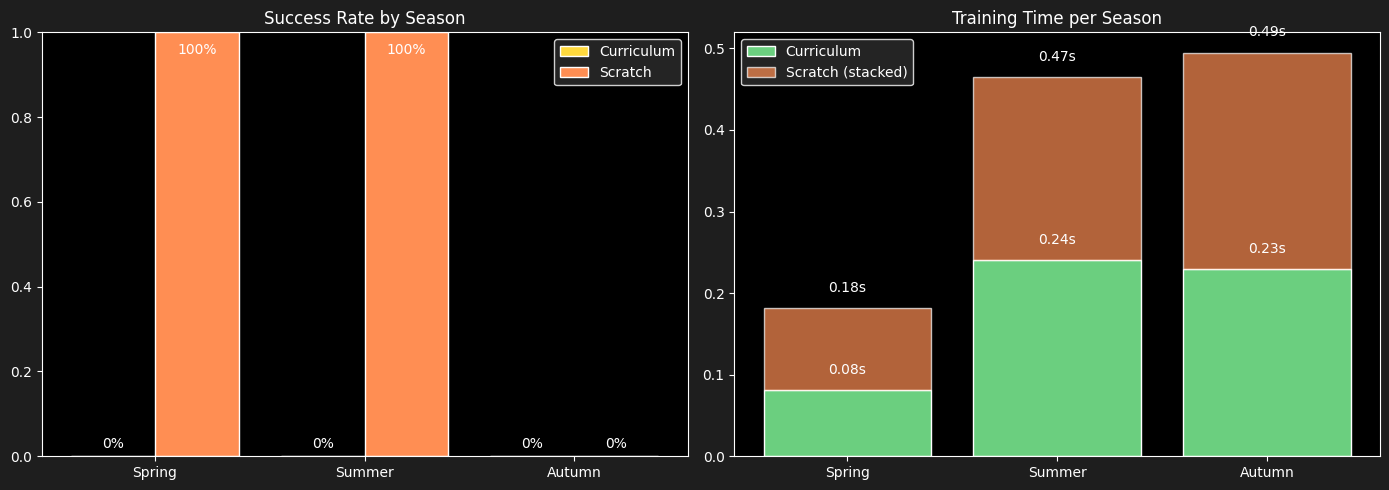

In [33]:
# TASK-3: Independent Curriculum Learning (Seasons)
import numpy as np
import matplotlib.pyplot as plt
import time

plt.style.use('dark_background')
COLORS = {'gold': '#FFD93D', 'teal': '#6BCF7F', 'orange': '#FF8E53'}

GRID_SIZE = 8
ACTIONS = ['U', 'D', 'L', 'R']
ACTION_MAP = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}

rng = np.random.default_rng(7)

# Seasonal configs with increasing difficulty
SEASONS = [
    {
        'name': 'Spring',
        'checkpoints': {(2, 2), (4, 4)},
        'puddles': {(3, 3)},
        'obstacles': {(1, 1)},
        'base': (7, 7)
    },
    {
        'name': 'Summer',
        'checkpoints': {(1, 3), (5, 2), (6, 6)},
        'puddles': {(2, 2), (4, 5), (3, 6)},
        'obstacles': {(1, 1), (4, 1)},
        'base': (0, 7)
    },
    {
        'name': 'Autumn',
        'checkpoints': {(0, 2), (2, 5), (4, 1), (7, 3)},
        'puddles': {(1, 4), (3, 2), (4, 7), (6, 3)},
        'obstacles': {(1, 1), (3, 3), (5, 5), (7, 7)},
        'base': (7, 0)
    }
]

ALPHA = 0.12
GAMMA = 0.92
EPSILON = 0.30
MIN_EPS = 0.05
EPISODES = 220
MAX_STEPS = 200
SHAPING_COEF = 0.4


def is_valid(s, obs):
    x, y = s
    return 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE and s not in obs


def manhattan(a, b):
    return abs(a[0]-b[0]) + abs(a[1]-b[1])


def next_goal(state, visited, cfg):
    remaining = list(cfg['checkpoints'] - visited)
    if remaining:
        return min(remaining, key=lambda g: manhattan(state, g))
    return cfg['base']


def step_env(s, a, cfg, visited):
    goal_before = next_goal(s, visited, cfg)
    d0 = manhattan(s, goal_before)

    dx, dy = ACTION_MAP[a]
    ns = (s[0] + dx, s[1] + dy)
    if not is_valid(ns, cfg['obstacles']):
        ns = s
    r = -1
    if ns in cfg['puddles']:
        r = -6
    elif ns in cfg['checkpoints'] and ns not in visited:
        visited.add(ns)
        r = 8
    elif ns == cfg['base'] and visited == cfg['checkpoints']:
        r = 30

    goal_after = next_goal(ns, visited, cfg)
    d1 = manhattan(ns, goal_after)
    r += SHAPING_COEF * (d0 - d1)
    return ns, r, visited


def select_action(Q, s, eps):
    if s not in Q or rng.random() < eps:
        return rng.choice(ACTIONS)
    return max(Q[s], key=Q[s].get)


def train_cfg(cfg, episodes=EPISODES, Q=None):
    if Q is None:
        Q = {}
    rewards = []
    t0 = time.time()
    for ep in range(episodes):
        s = (0, 0)
        visited = set()
        total = 0.0
        eps = max(MIN_EPS, EPSILON * (1 - ep/episodes))
        for _ in range(MAX_STEPS):
            if s not in Q:
                Q[s] = {a: 0.0 for a in ACTIONS}
            a = select_action(Q, s, eps)
            ns, r, visited = step_env(s, a, cfg, visited)
            if ns not in Q:
                Q[ns] = {a: 0.0 for a in ACTIONS}
            Q[s][a] += ALPHA * (r + GAMMA * max(Q[ns].values()) - Q[s][a])
            total += r
            if ns == cfg['base'] and visited == cfg['checkpoints']:
                break
            s = ns
        rewards.append(total)
    return Q, rewards, time.time() - t0

# Curriculum: progress through seasons, carrying Q forward
print("TASK-3: Curriculum learning across seasons…")
Q, history, times = None, {}, {}
for cfg in SEASONS:
    Q, hist, t = train_cfg(cfg, Q=Q)
    history[cfg['name']] = hist
    times[cfg['name']] = t

# From-scratch baselines per season
scratch_hist, scratch_times = {}, {}
for cfg in SEASONS:
    Qs, hs, ts = train_cfg(cfg, Q=None)
    scratch_hist[cfg['name']] = hs
    scratch_times[cfg['name']] = ts

# Simple greedy eval

def eval_cfg(Q, cfg, episodes=80):
    succ, rews = 0, []
    for _ in range(episodes):
        s, visited, total = (0, 0), set(), 0.0
        for _ in range(MAX_STEPS):
            if s not in Q:
                a = rng.choice(ACTIONS)
            else:
                a = max(Q[s], key=Q[s].get)
            ns, r, visited = step_env(s, a, cfg, visited)
            total += r
            if ns == cfg['base'] and visited == cfg['checkpoints']:
                succ += 1
                break
            s = ns
        rews.append(total)
    return succ/episodes, float(np.mean(rews))

curr_success, scratch_success = [], []
for cfg in SEASONS:
    s_curr, _ = eval_cfg(Q, cfg)
    Qs, _, _ = train_cfg(cfg, Q=None)  # freshly trained policy per season
    s_scr, _ = eval_cfg(Qs, cfg)
    curr_success.append(s_curr)
    scratch_success.append(s_scr)

# Plots
names = [cfg['name'] for cfg in SEASONS]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), facecolor='#1e1e1e')

# Success bars
x = np.arange(len(names))
ax1.bar(x-0.2, curr_success, width=0.4, color=COLORS['gold'], edgecolor='white', linewidth=1, label='Curriculum')
ax1.bar(x+0.2, scratch_success, width=0.4, color=COLORS['orange'], edgecolor='white', linewidth=1, label='Scratch')
ax1.set_xticks(x); ax1.set_xticklabels(names, color='white')
ax1.set_ylim(0, 1)
ax1.set_title('Success Rate by Season', color='white')
ax1.legend(facecolor='#2e2e2e', edgecolor='white', labelcolor='white')
ax1.tick_params(colors='white')
for i, v in enumerate(curr_success):
    ax1.text(i-0.2, min(0.95, v+0.02), f"{v:.0%}", color='white', ha='center')
for i, v in enumerate(scratch_success):
    ax1.text(i+0.2, min(0.95, v+0.02), f"{v:.0%}", color='white', ha='center')

# Time bars
ct = [times[n] for n in names]
st = [scratch_times[n] for n in names]
ax2.bar(names, ct, color=COLORS['teal'], edgecolor='white', linewidth=1, label='Curriculum')
ax2.bar(names, st, bottom=ct, color=COLORS['orange'], alpha=0.7, edgecolor='white', linewidth=1, label='Scratch (stacked)')
ax2.set_title('Training Time per Season', color='white')
ax2.legend(facecolor='#2e2e2e', edgecolor='white', labelcolor='white')
ax2.tick_params(colors='white')
for i, (a, b) in enumerate(zip(ct, st)):
    ax2.text(i, a+0.02, f"{a:.2f}s", color='white', ha='center')
    ax2.text(i, a+b+0.02, f"{(a+b):.2f}s", color='white', ha='center')

plt.tight_layout()
plt.show()